In [1]:
import os
from os.path import join
import sys
import numpy as np 
import pandas as pd
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Eye Bias Analysis
Test whether there is a bias toward either the left or right eye, and whether
that bias changes by gender

"left" is relative to the viewer (i.e. the 'right' anatomically)

In [3]:
# load the combined cursorTracking data for all subjs
df = pd.read_table('../../data/groupData/allSubjsRaw.tsv', sep='\t')

In [4]:
df.shape

(608261, 7)

In [5]:
df.head()

,ts,x,y,subjID,stim,trialNum,AOI
0,98,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
1,123,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
2,154,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
3,172,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
4,188,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none


### Select the stimuli to include in analysis
For the eye-bias analysis, use the bw_hmn and hmn stimuli only

In [6]:
# select the relevant rows from the full dataframe
df2 = df.loc[(df['stim'].str.contains("_images707/bw_hmn/")) | 
             (df['stim'].str.contains("_images707/hmn/"))]


In [7]:
df2.shape

(105400, 7)

In [8]:
df2.head()

,ts,x,y,subjID,stim,trialNum,AOI
0,98,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
1,123,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
2,154,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
3,172,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
4,188,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none


### Create within-subject averages for the within-trial eye bias score
For each trial for each subject, calculate the mean time per AOI. The mean time for each AOI is calculated by taking the mean frame interval across that trial (i.e. the mean interval between successive timestamps) and multiplying it by the number of frames labeled for each AOI.

e.g. On a given trial:

 * 298 frames
 * 16.8 mean frame interval
 * 67 frames labeled 'leftEye'

would return 1125ms spent on 'leftEye' for that trial. For every trial, the eye-bias score is calculated as the leftEye - rightEye time. For each subject, the eye bias scores are averaged across all trials

In [9]:
# loop over all unique subjects
subjMeans = []
for s in np.unique(df2.subjID):
    # grab this subjects data
    subj_df = df2.loc[df2.subjID == s]
    
    # loop through unique trials
    trial_eyeBias = []
    for i,t in enumerate(np.unique(subj_df.trialNum)):
        # grab this trial's data
        trial_df = subj_df[subj_df.trialNum == t]
        
        # calculate mean time/frame
        meanFrameInterval = trial_df.ts.diff().mean()
        
        # get number of frames for each AOI
        AOI_counts = trial_df.AOI.value_counts()
        
        # multiple frame counts by mean frame interval to get time spent in the AOI
        AOI_time = AOI_counts * meanFrameInterval
        
        # make sure left and right eye are represented
        if 'leftEye' not in AOI_time:
            AOI_time.leftEye = 0
        if 'rightEye' not in AOI_time:
            AOI_time.rightEye = 0
        
        # calculate bias score
        eyeBias = AOI_time.leftEye - AOI_time.rightEye
        
        # append to the list of bias for all trials
        trial_eyeBias.append(eyeBias)

    # calculate the mean across trials
    subj_eyeBias = np.mean(trial_eyeBias)
    
    # create a series out of it
    thisSubj = pd.Series({'eyeBias': subj_eyeBias}, name=s)
    subjMeans.append(thisSubj)
    
allSubjs = pd.concat(subjMeans, axis=1).T
    

In [10]:
allSubjs.head()

,eyeBias
741,310.135744
1164,197.855359
20649,-70.862152
27235,-391.586942
27537,278.392258


In [11]:
np.mean(allSubjs)

eyeBias    68.292473
dtype: float64

#### is there an overall bias toward the left eye in this dataset?

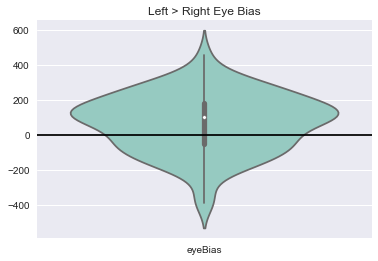

In [12]:
# plot
sns.violinplot(data=allSubjs, palette='Set3')
sns.plt.title('Left > Right Eye Bias')
plt.axhline(y=0, color='k')


In [13]:
import scipy.stats as stats

In [14]:
# run the t-test

stats.ttest_1samp(allSubjs, 0)

Ttest_1sampResult(statistic=array([ 3.50078093]), pvalue=array([ 0.00080045]))

### Does this bias vary as a function of subject gender?
Load in the demographic data on the subjects, pull out gender, link to every subject in the allSubjs dataframe

In [15]:
dem_data = pd.read_table('../../data/groupData/AbsFace Demographics_May 11, 2017_19.30.csv', sep=',')

Q1 - WBL ID;
Q2 - Age;
Q3 - Gender

In [16]:
dem_data = dem_data[['Q1', 'Q2', 'Q3']]

In [17]:
a = dem_data[dem_data.Q1.str.find('31758') == 0]

In [18]:
a.Q3.values[0]

'Male'

In [19]:
def labelGender(row):
    "find the gender based on subjID"
    subjID = str(row.name) # get the subjID
    
    # grab the row with the subject's demographic data
    subj_dem = dem_data[dem_data.Q1.str.find(subjID) == 0]
    
    return subj_dem.Q3.values[0]
    

In [20]:
allSubjs['gender'] = allSubjs.apply(labelGender, axis=1)

In [21]:
# remove rows not labeled as 'Male' or 'Female'
allSubjs = allSubjs[(allSubjs.gender == 'Male') | (allSubjs.gender == 'Female')]

In [22]:
allSubjs.groupby('gender').mean()

,eyeBias
gender,
Female,92.328649
Male,20.741567


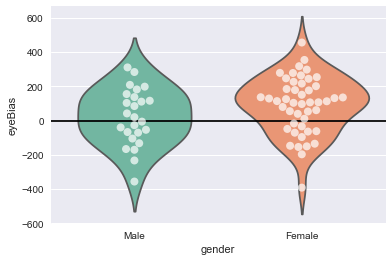

In [23]:
# plot distribution of results
sns.violinplot(x=allSubjs.gender, y=allSubjs.eyeBias, inner=None, palette='Set2')
sns.swarmplot(x=allSubjs.gender, y=allSubjs.eyeBias, color="w", size=8, alpha=.7)
plt.axhline(y=0, color='black')

In [24]:
# stats
M = allSubjs.eyeBias[allSubjs.gender=='Male']
F = allSubjs.eyeBias[allSubjs.gender=='Female']

stats.ttest_ind(M, F, equal_var=True)

Ttest_indResult(statistic=-1.7493499840780939, pvalue=0.08461348643253451)